In [1]:
from GAN.CGAN import ConditionalGAN
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import IPython


2024-05-10 20:58:24.838424: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 20:58:24.930469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
screenshots_dataset = pickle.load(open("genre_dataset.pkl", "rb"))
X, y = screenshots_dataset
print(X.shape)

(5000, 64, 64, 3)


In [3]:
print(set(y))

{'Strategy', 'Casual', 'Adventure', 'Action', 'Simulation'}


In [4]:
len(set(y))

5

In [5]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
category_dict = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
y_onehot = OneHotEncoder().fit_transform(y_encoded.reshape(-1, 1)).toarray()

In [6]:
print(category_dict)

{'Action': 0, 'Adventure': 1, 'Casual': 2, 'Simulation': 3, 'Strategy': 4}


In [7]:
print(X.shape, y_onehot.shape)

(5000, 64, 64, 3) (5000, 5)


In [8]:
# shuffle the dataset
np.random.seed(0)
idx = np.random.permutation(len(X))
X = X[idx]
y_onehot = y_onehot[idx]

In [9]:
# code adapted from lab 8 (GAN)
import matplotlib.pyplot as plt
from PIL import Image
import io

class EpochVisualizer(tf.keras.callbacks.Callback):
    def __init__(self, model, sample_inputs, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.sample_inputs = sample_inputs
        self.imgs = []

    def on_epoch_end(self, epoch, logs=None):
        x_real, z_samp, class_labels = self.sample_inputs
        class_labels_image = class_labels[:, :, None, None]

        img_width = 64
        num_classes = 5
        class_labels_image = tf.repeat(class_labels_image, repeats=[img_width * img_width])
        class_labels_image = tf.reshape(class_labels_image, (-1, img_width, img_width, num_classes))
        class_labels_image = tf.cast(class_labels_image, tf.float32)
        
        #x_fake = self.model.gen_model(z_samp, class_labels)
        x_fake = self.model.gen_model(tf.concat([z_samp, class_labels], axis=-1))
        d_real = self.model.dis_model(tf.concat([x_real, class_labels_image], axis=-1))
        d_fake = self.model.dis_model(tf.concat([x_fake, class_labels_image], axis=-1))
        outputs = tf.concat([x_real, x_fake], axis=0)
        labels  = [f"D(true x) = {np.round(100 * d, 0)}%" for d in d_real]
        labels += [f"D(fake x) = {np.round(100 * d, 0)}%" for d in d_fake]

        self.add_to_imgs(
            outputs = outputs,
            labels = labels,
            epoch = epoch
        )

    def add_to_imgs(self, outputs, labels, epoch, nrows=1, ncols=8, figsize=(20, 7)):
        '''
        Plot the image samples in outputs in a pyplot figure and add the image
        to the 'imgs' list. Used to later generate a gif.
        '''
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        if nrows == 1: axs = np.array([axs])
        fig.suptitle(f'Epoch {epoch+1}')
        axs[0][0].set_title(f'Epoch {epoch+1}')
        for i, ax in enumerate(axs.reshape(-1)):
            #out_numpy = np.squeeze(outputs[i].numpy(), -1)
            #ax.imshow(out_numpy, cmap='gray')
            out_numpy = outputs[i]
            out_numpy = (out_numpy+1)/2

            ax.imshow(out_numpy)
            ax.set_title(labels[i])
        self.imgs += [self.fig2img(fig)]
        plt.close(fig)

    @staticmethod
    def fig2img(fig):
        """
        Convert a Matplotlib figure to a PIL Image and return it
        https://stackoverflow.com/a/61754995/5003309
        """
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        return Image.open(buf)

    def save_gif(self, filename='mnist_recon', loop=True, duration=500):
        imgs = self.imgs
        self.imgs[0].save(
            filename+'.gif', save_all=True, append_images=self.imgs[1:],
            loop=loop, duration=duration)

In [10]:
g_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
d_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

#d_opt = tf.keras.optimizers.SGD(learning_rate=0.0002)


bce_func = tf.keras.backend.binary_crossentropy
acc_func = tf.keras.metrics.binary_accuracy

def d_acc_fake(d_fake:tf.Tensor, d_real:tf.Tensor)  -> tf.Tensor:
    return tf.reduce_mean(acc_func(tf.zeros_like(d_fake), d_fake))

def d_acc_real(d_fake:tf.Tensor, d_real:tf.Tensor)  -> tf.Tensor:
    return tf.reduce_mean(acc_func(tf.ones_like(d_real), d_real))

def g_acc(d_fake:tf.Tensor, d_real:tf.Tensor) -> tf.Tensor:
    return tf.reduce_mean(acc_func(tf.ones_like(d_fake), d_fake))


cgan_model = ConditionalGAN(
    num_classes  = len(set(y)),
    img_shape = (64, 64, 3),
    latent_dim = 300,
    name       = "cgan"
)

cgan_model.compile(
    optimizers = {
        'd_opt' : d_opt,
        'g_opt' : g_opt
    },
    losses = {
        'loss_func': tf.keras.losses.BinaryCrossentropy(),
    },
    accuracies = {
        'd_acc_real' : d_acc_real,
        'd_acc_fake' : d_acc_fake,
        'g_acc'      : g_acc,
    }
)



train_num = 2500       
true_sample = X[train_num-4:train_num]
fake_sample = cgan_model.z_sampler((4, cgan_model.latent_dim))   ## 4 fake images
labels = y_onehot[train_num-4:train_num]
viz_callback = EpochVisualizer(cgan_model, [true_sample, fake_sample, labels])


cgan_model.fit(
    X, y_onehot,
    d_steps    = 3,
    g_steps    = 1,
    epochs     = 100, 
    batch_size = 50,
    callbacks  = [viz_callback]
)   



2024-05-10 20:58:29.447445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 20:58:29.510851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 20:58:29.513927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2024-05-10 20:58:36.902061: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inconditional_discriminator/dropout/dropout_1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-10 20:58:37.834729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-10 20:58:37.904135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-05-10 20:58:39.393597: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff3d796b6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-10 20:58:39.393676: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA H100 PCIe, Compute Capability 9.0
2024-05-10 20:58:39.404459: I tensorflow/compiler/mlir/tensorflow/utils/dum

In [ ]:
cgan_model.save_weights('new_trained_cgan3')

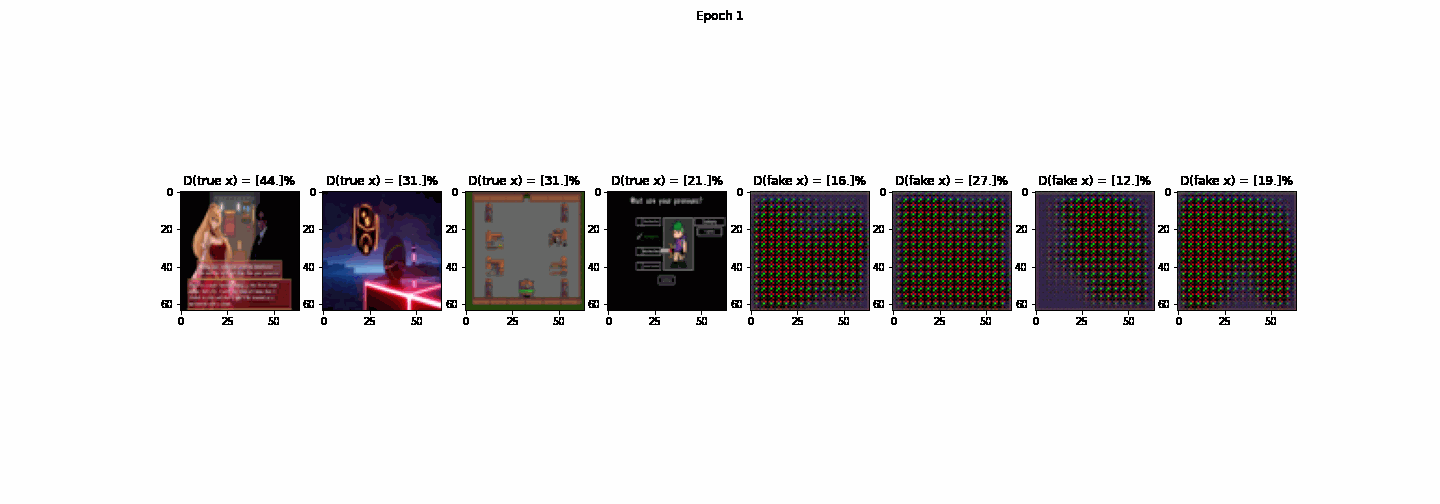

In [ ]:
viz_callback.save_gif('genre_generation3')
IPython.display.Image(open('genre_generation3.gif','rb').read())

In [ ]:
print(labels)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]


In [ ]:
print(category_dict)

{'Action': 0, 'Adventure': 1, 'Casual': 2, 'Simulation': 3, 'Strategy': 4}


In [ ]:
label_lookup = {value: key for key, value in category_dict.items()}

In [ ]:
import keras
n = 3
imgs = []

for i in range(5):
    print(f'generating genre {i}')
    z = cgan_model.sample_z(n)
    class_label = keras.utils.to_categorical(i, num_classes=5)
    class_label = tf.expand_dims(class_label, 0)
    class_label = tf.repeat(class_label, repeats=[n], axis=0)
    z_with_labels = tf.concat([z, class_label], -1)
    imgs.append(cgan_model.gen_model(z_with_labels))

generating genre 0
generating genre 1
generating genre 2
generating genre 3
generating genre 4


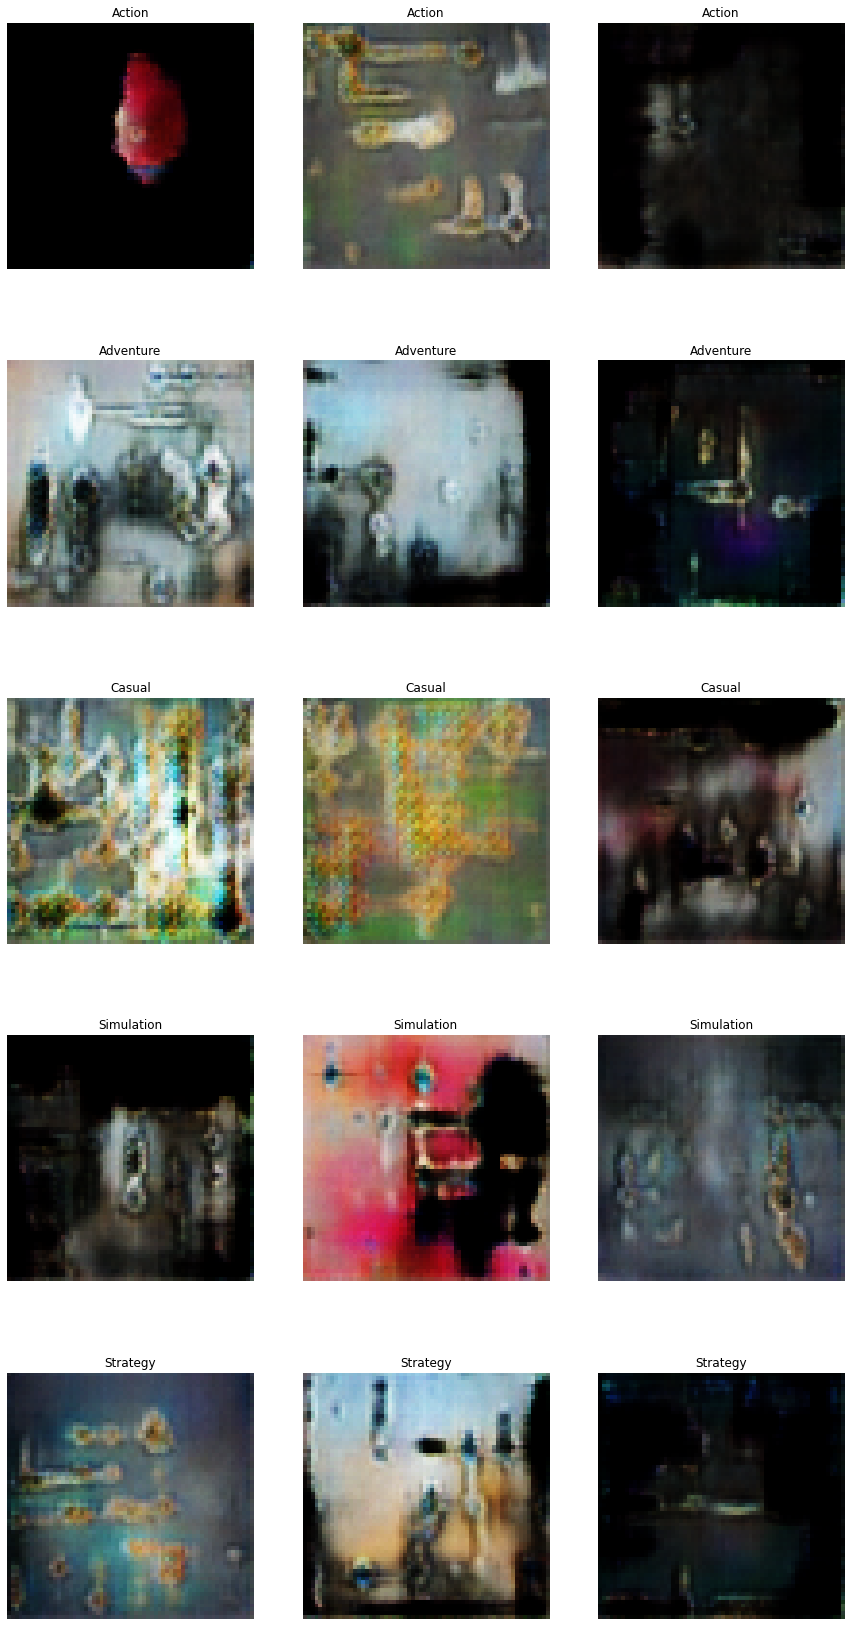

In [ ]:
fig, ax = plt.subplots(n, 5, figsize=(25,10))
for j in range(len(imgs)):
    for i in range(n):
        out = imgs[i][j]
        out = (out+1)/2
        ax[i,j].imshow(out)
        ax[i,j].set_title(f'{label_lookup[i]}')
        ax[i,j].axis('off')

In [ ]:
fig.savefig('generated_samples3.jpg', dpi=300, bbox_inches='tight')

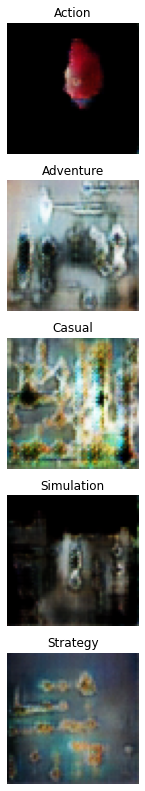

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(7,14))
for i in range(len(imgs)):

    out = imgs[i][0]
    out = (out+1)/2
    ax[i].imshow(out)
    ax[i].set_title(f'{label_lookup[i]}')
    ax[i].axis('off')

In [1]:
import numpy as np
import matplotlib.pyplot as plt

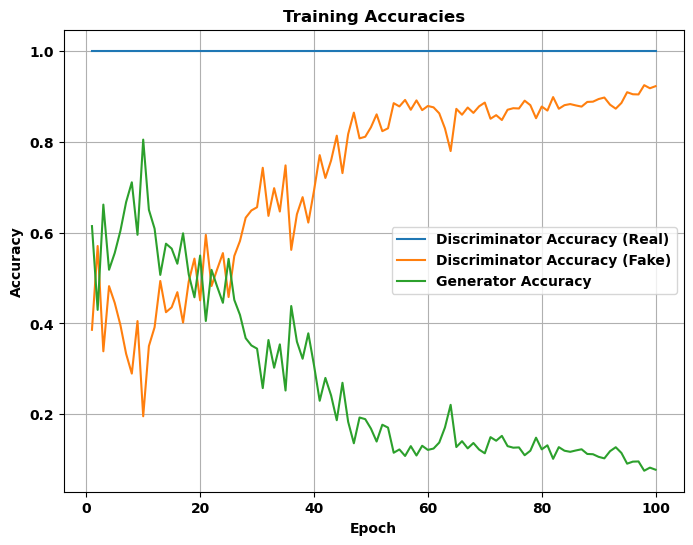

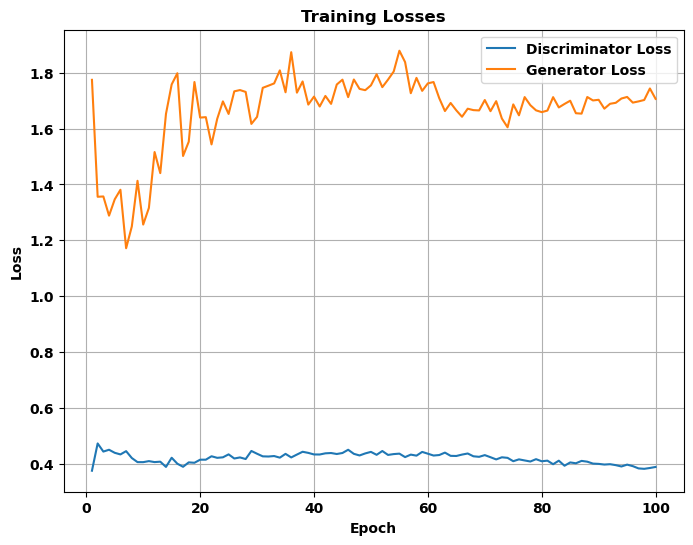

In [2]:
with open('train_log_100.txt', 'r') as file:
    document_content = file.read()

epochs = []
d_acc_real = []
d_acc_fake = []
g_acc = []
d_loss = []
g_loss = []

for line in document_content.split('\n'):
    if 'Epoch' in line:
        epoch = int(line.split('/')[0].split()[-1])
        epochs.append(epoch)
    if 'd_acc_real' in line:
        d_acc_real.append(float(line.split('d_acc_real:')[1].split('-')[0]))
    if 'd_acc_fake' in line:
        d_acc_fake.append(float(line.split('d_acc_fake:')[1].split('-')[0]))
    if 'g_acc' in line:
        g_acc.append(float(line.split('g_acc:')[1].split('-')[0]))
    if 'd_loss' in line:
        d_loss.append(float(line.split('d_loss:')[1].split('-')[0]))
    if 'g_loss' in line:
        g_loss.append(float(line.split('g_loss:')[1].split('-')[0]))

# Plot accuracies
plt.figure(figsize=(8, 6))
plt.plot(epochs, d_acc_real, label='Discriminator Accuracy (Real)')
plt.plot(epochs, d_acc_fake, label='Discriminator Accuracy (Fake)')
plt.plot(epochs, g_acc, label='Generator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()
plt.grid(True)
plt.show()

# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(epochs, d_loss, label='Discriminator Loss')
plt.plot(epochs, g_loss, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.show()